# MintPy Processing

In [17]:
# %matplotlib widget
%matplotlib inline
import glob
import sys
import shutil
import os
import matplotlib.pyplot as plt
from mintpy import workflow, view, tsview, plot_network, plot_transection, plot_coherence_matrix

In [3]:
cd /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy

/u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy


In [5]:
!smallbaselineApp.py -g

--------------------------------------------------
Go to work directory: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy
copy default template file /home/fwilliam/tools/MintPy/mintpy/defaults/smallbaselineApp.cfg to work directory
copy smallbaselineApp.cfg to inputs   directory for backup.
copy smallbaselineApp.cfg to pic      directory for backup.
read default template file: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy/smallbaselineApp.cfg
Go back to directory: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy

################################################
   Normal end of smallbaselineApp processing!
################################################
Time used: 00 mins 0.0 secs



In [2]:
!pwd

/u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy


In [3]:
!nproc

32


In [5]:
# ~30 GB of ram
!cat /proc/meminfo

MemTotal:       131447096 kB
MemFree:        27293156 kB
MemAvailable:   44729476 kB
Buffers:           13920 kB
Cached:         14223400 kB
SwapCached:          112 kB
Active:          8565776 kB
Inactive:        8812456 kB
Active(anon):    3078256 kB
Inactive(anon):   187888 kB
Active(file):    5487520 kB
Inactive(file):  8624568 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:       4194296 kB
SwapFree:        4189424 kB
Dirty:                 0 kB
Writeback:             0 kB
AnonPages:       3109600 kB
Mapped:           214720 kB
Shmem:            125232 kB
Slab:           28174844 kB
SReclaimable:    3950240 kB
SUnreclaim:     24224604 kB
KernelStack:       19872 kB
PageTables:        23836 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:    69917844 kB
Committed_AS:   21244252 kB
VmallocTotal:   34359738367 kB
VmallocUsed:     4136692 kB
VmallocChunk:   34286476152 kB
Percpu:            81920 kB
HardwareCorru

## A note on the los files:

**From Eric:** Checked the geom_reference/los.rdr file and it is actually BSQ, but the los.rdr.xml file has the scheme as BIP. This explains why MintPy is reading it wrong. Hand-edited the xml file and ran fixImageXml.py to generate the corrected los.rdr.vrt file. Also edited the los.rdr.rsc file to correct the scheme there.

## load_data

In [23]:
!smallbaselineApp.py ../JPL_internship/Haywrd_05502_01-S1.cfg --dostep load_data

MintPy release version v1.3.0-83, release date 2021-07-30
--RUN-at-2021-08-03 14:35:39.385145--
Current directory: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy
Run routine processing with smallbaselineApp.py on steps: ['load_data']
Remaining steps: ['modify_network', 'reference_point', 'quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: Haywrd_05502_01-S1
Go to work directory: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy
read custom template file: /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/JPL_internship/Haywrd_05502_01-S1.cfg
update default template based on input custom template
No new option value found, skip updating /u/sar-r2/fwilliam/Calif/UAVSAR/Stacks/Haywrd_05502_01-S1/mintpy/smallbase

## Check for correct loading of incidence and azimuth angle files

view.py inputs/geometryRadar.h5 azimuthAngle incidenceAngle --noverbose


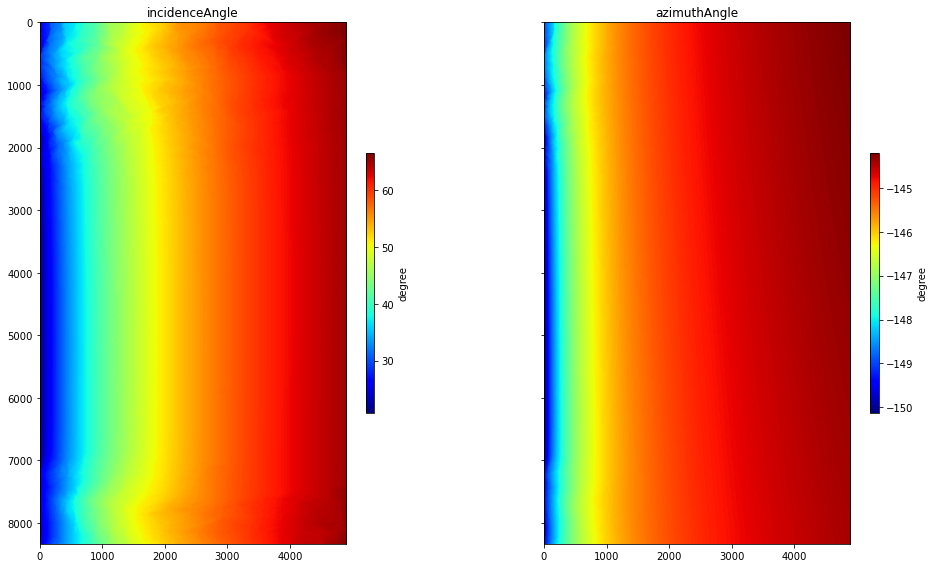

In [24]:
fig = view.main('inputs/geometryRadar.h5 azimuthAngle incidenceAngle --noverbose'.split())

Outputs look good!